In [2]:
import pandas as pd
import numpy as np
import os
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = kagglehub.dataset_download("nasa/kepler-exoplanet-search-results")
df = pd.read_csv(os.path.join(path, "cumulative.csv"))
print("Dataset downloaded and loaded successfully.")

100%|███████████████████████████████████████| 1.16M/1.16M [00:01<00:00, 759kB/s]

Extracting files...
Dataset downloaded and loaded successfully.


In [6]:
# Drop unnecessary columns
df = df.drop(columns=['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname'])

# Drop columns with a high percentage of missing values
df = df.dropna(axis='columns', how='all')
df = df.dropna()

In [8]:
# Select features based on domain knowledge and feature importance observed in similar studies.
# We will keep features that describe the transit properties and stellar parameters.
features_to_keep = [
    'koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
    'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
    'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1',
    'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2',
    'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol',
    'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_steff',
    'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1',
    'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra',
    'dec', 'koi_kepmag'
]

df = df[features_to_keep]

In [10]:
# Encode the target variable 'koi_disposition'
# We are interested in 'CONFIRMED' vs 'FALSE POSITIVE'
df = df[df['koi_disposition'] != 'CANDIDATE']
le = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df['koi_disposition'] = df['koi_disposition'].map(le)

In [12]:
# Separate features (X) and target (y)
X = df.drop('koi_disposition', axis=1)
y = df['koi_disposition']

In [14]:
# Using SMOTE to oversample the minority class (CONFIRMED exoplanets)
print("Handling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class imbalance handled.")

Handling class imbalance with SMOTE...
Class imbalance handled.


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [18]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

In [22]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

In [27]:
# Use GridSearchCV to find the best hyperparameters
print("Starting hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
print("Hyperparameter tuning complete.")

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Hyperparameter tuning complete.


In [29]:
# Get the best estimator
best_rf = grid_search.best_estimator_

In [31]:
# Make predictions on the test set
y_pred = best_rf.predict(X_test_scaled)

In [33]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 99.48%


In [35]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       872
           1       1.00      0.99      0.99       872

    accuracy                           0.99      1744
   macro avg       0.99      0.99      0.99      1744
weighted avg       0.99      0.99      0.99      1744




Confusion Matrix:


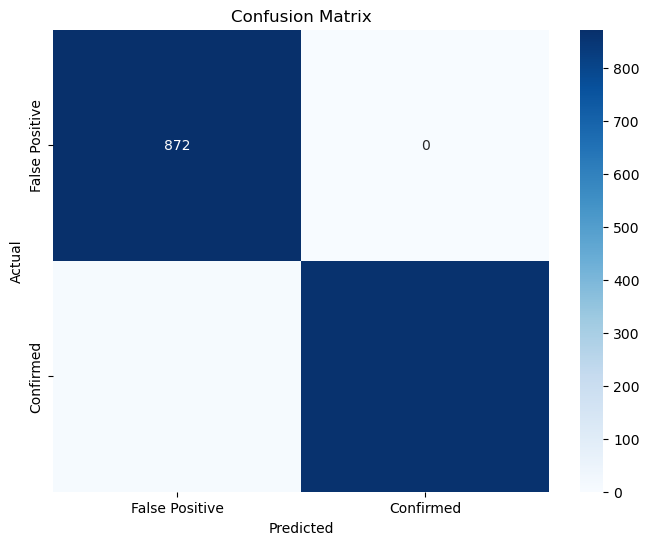

In [37]:
# Display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False Positive', 'Confirmed'], yticklabels=['False Positive', 'Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# --- Feature Importance ---
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [41]:
print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))


Top 10 Feature Importances:
                   importance
koi_fpflag_co        0.146544
koi_fpflag_ss        0.097747
koi_prad             0.067054
koi_fpflag_nt        0.059536
koi_steff_err1       0.057596
koi_steff_err2       0.052425
koi_prad_err2        0.050139
koi_prad_err1        0.048698
koi_fpflag_ec        0.043369
koi_duration_err2    0.037510
